In [24]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
sns.set_style('whitegrid')
plt.style.use('ggplot')

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score
import collections
%matplotlib inline

In [2]:
# Load the data into DataFrames
df_train = pd.read_csv('/content/drive/MyDrive/台新/train_users_2.csv')
df_test = pd.read_csv('/content/drive/MyDrive/台新/test_users.csv')
df_sessions = pd.read_csv('/content/drive/MyDrive/台新/sessions.csv')
df_usergrp = pd.read_csv('/content/drive/MyDrive/台新/age_gender_bkts.csv')
df_country = pd.read_csv('/content/drive/MyDrive/台新/countries.csv')

In [ ]:
# explore shape of Data
print('shape of train data', df_train.shape)
print('shape of test data',df_test.shape)
print('unique User ID in train data',len(set(df_train['id'])))
print('unique User ID in test data',len(set(df_test['id'])))
print('unique User ID in sessions data',len(set(df_sessions['user_id'])))
print('unique User ID in sessions and train data',len(set(df_train['id']).intersection(set(df_sessions['user_id']))))
print("Ratio of user in Train Data with session info:",len(set(df_train['id']).intersection(set(df_sessions['user_id'])))/df_train.shape[0])
print('unique User ID in sessions and test data',len(set(df_test['id']).intersection(set(df_sessions['user_id']))))
print("Ratio of user in Test Data with session info:",len(set(df_test['id']).intersection(set(df_sessions['user_id'])))/df_test.shape[0])
print('unique countries in data',len(df_country))

shape of train data (213451, 16)
shape of test data (62096, 15)
unique User ID in train data 213451
unique User ID in test data 62096
unique User ID in sessions data 135484
unique User ID in sessions and train data 73815
Ratio of user in Train Data with session info: 0.34581707277079987
unique User ID in sessions and test data 61668
Ratio of user in Test Data with session info: 0.9931074465343983
unique countries in data 10


In [ ]:
df_user = pd.concat((df_train, df_test), axis=0, ignore_index=True)

facts: 測試集中的 user 有近全部含 session data，但 train data 中的 user 僅 34%

**使用者旅程 - 漏斗分析**

In [ ]:
df_sessions.info()
df_sessions.head()

#fact:一個user有多個欄位，紀錄他的行為，或為時序性

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


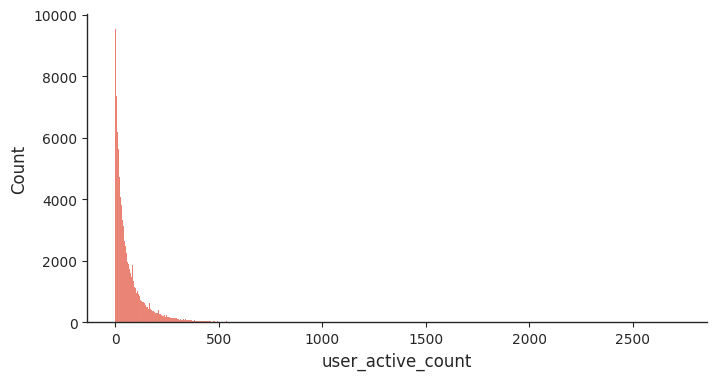

In [ ]:
user_active_count = list(df_sessions['user_id'].value_counts())

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.histplot(user_active_count)
plt.xlabel('user_active_count')
sns.despine()

In [109]:
#進站用戶
visit_user = len(df_sessions['user_id'].unique())

#活躍用戶
grouped_counts = df_sessions.groupby('user_id').size()
active_user = len(grouped_counts[grouped_counts > grouped_counts.describe()['25%']]) #閥值設為16

#註冊用戶
registered_user = pd.merge(df_train, df_sessions['user_id'].drop_duplicates(), how='inner', left_on='id', right_on='user_id').shape[0]

#下單用戶
reservation_user = df_sessions.query("action_detail == 'reservations'")['user_id'].nunique()

#支付用戶
transcation_user = df_sessions.query("action_detail == 'payment_instruments'")['user_id'].nunique()

#複購用戶
count = df_sessions.query("action_detail == 'reservations'").groupby('user_id').size()
repeat_user = len(count[count > 1])

In [118]:
fig = go.Figure(go.Funnel(
    y = ['進站用戶', '活躍用戶', '註冊用戶', '下單用戶', '支付用戶', '複購用戶'],
    x = [visit_user, active_user, registered_user, reservation_user, transcation_user, repeat_user],
    textposition = "inside",
    textinfo = "value + percent previous"
    , marker = {"color": ["#1f77b4","#1f77b4","#dda0dd","#dda0dd","#1f77b4","#1f77b4"]})
    )

fig.show()

#fact
#註冊用戶到下單用戶的流失率最高，下單用戶僅占註冊用戶的14%
#後三階段的轉化率較好，複購用戶近六成%的轉化率說明用戶的回購意願較高，擁有較高的忠誠度

**渠道分析**

* 抓出各階段轉化率較好之渠道

In [3]:
df_train['affiliate_channel_provider'] = ""
df_train['affiliate_channel_provider'] = df_train['affiliate_channel'] + '_' + df_train['affiliate_provider']

In [4]:
#註冊與下單用戶比例

result = df_train.groupby('affiliate_channel_provider').agg(
    渠道用户=('id', 'count'),
    下單用户=('date_first_booking', lambda x: x.notna().sum()),
    下單轉化率=('date_first_booking', lambda x: '{:.2%}'.format(x.notna().sum() / x.notna().count()) if x.notna().count() > 0 else 0)
).reset_index().sort_values('渠道用户', ascending=False)


In [ ]:
# 取出前 10 高的渠道
top10 = result.sort_values('渠道用户', ascending=False).head(10)

# 計算全體渠道用戶數
total_users = result['渠道用户'].sum()

# 計算每個渠道用戶佔全體渠道用戶的占比
top10['占比'] = top10['渠道用户'] / total_users

# 繪製橫式長條圖
fig = go.Figure(
    go.Bar(
        x=top10['渠道用户'],
        y=top10['affiliate_channel_provider'],
        orientation='h',
        text=top10['占比'].apply(lambda x: f'{x:.2%}'),
        textposition='outside',
        marker=dict(color='#1f77b4')
    )
)

# 設置圖的標題和軸標籤
fig.update_layout(
    title='Affiliate Channel Users',
    xaxis_title='registered_user',
    yaxis={'categoryorder':'array', 'categoryarray':result['affiliate_channel_provider'].tolist()[::-1]}
)

# 顯示圖形
fig.show()


In [ ]:
#排除Direct

top10 = result[1:].sort_values('渠道用户', ascending=False).head(10)

# 計算全體渠道用戶數
total_users = result[1:]['渠道用户'].sum()

# 計算每個渠道用戶佔全體渠道用戶的占比
top10['占比'] = top10['渠道用户'] / total_users

# 繪製橫式長條圖
fig = go.Figure(
    go.Bar(
        x=top10['渠道用户'],
        y=top10['affiliate_channel_provider'],
        orientation='h',
        text=top10['占比'].apply(lambda x: f'{x:.2%}'),
        textposition='outside',
        marker=dict(color='#1f77b4')
    )
)

# 設置圖的標題和軸標籤
fig.update_layout(
    title='Affiliate Channel Users without direct',
    xaxis_title='registered_user',
    yaxis={'categoryorder':'array', 'categoryarray':result[1:]['affiliate_channel_provider'].tolist()[::-1]}
)

# 顯示圖形
fig.show()

fact
* 註冊用戶來源符合二八法則，總共15個渠道，前三渠道貢獻 85.03% 的註冊用戶
* Direct(直接 app store 下載)的註冊用戶數最多，有137403個用戶，占比64.4%
* 不含 direct 圖表，前四渠道貢獻 76.77% 的註冊用戶，大致也符合二八法則 

In [146]:
#註冊用戶數中的下訂用戶數占比

#排除 direct 與樣本過少的渠道
result_nodirect = result[1:23].rename(columns={'渠道用户':'註冊用戶'}).reset_index()
result_nodirect['下單轉化率'] = result_nodirect['下單轉化率'].apply(lambda x: float(x.strip('%')))

# 計算橫軸和縱軸的平均值
avg_users = result_nodirect['註冊用戶'].mean()
avg_conversion_rate = result_nodirect['下單轉化率'].mean()

# 創建顏色數組
colors = np.array(['grey'] * len(result_nodirect))
colors[(result_nodirect['註冊用戶'] > avg_users) & (result_nodirect['下單轉化率'] > avg_conversion_rate)] = 'blue'
colors[(result_nodirect['註冊用戶'] <= avg_users) & (result_nodirect['下單轉化率'] > avg_conversion_rate)] = 'red'

# 創建圖形佈局
fig = go.Figure()

# 添加散點圖
fig.add_trace(go.Scatter(x=result_nodirect['註冊用戶'], 
             y=result_nodirect['下單轉化率'], 
             mode='markers',marker=dict(color=colors, size=10),
             text=result_nodirect['affiliate_channel_provider'], hoverinfo='text'))

# 設置圖形樣式
fig.update_layout(title='各管道於註冊用戶數與下單轉化率關係圖',
          xaxis_title='註冊用戶數',
          yaxis_title='下單轉化率 (%)',
          xaxis=dict(showline=True, linewidth=1, linecolor='black',
                      mirror=True, ticks='inside', tickwidth=1, ticklen=5),
          yaxis=dict(showline=True, linewidth=1, linecolor='black',
                      mirror=True, ticks='inside', tickwidth=1, ticklen=5),
          plot_bgcolor='white', margin=dict(l=50, r=50, t=50, b=50)
          ,width=800,height=400)

# 加入橫軸和縱軸的平均值
fig.add_shape(type='line', x0=0, y0=avg_conversion_rate, x1=result_nodirect['註冊用戶'].max(), y1=avg_conversion_rate,
              line=dict(color='black', width=2, dash='dash'))
fig.add_shape(type='line', x0=avg_users, y0=0, x1=avg_users, y1=result_nodirect['下單轉化率'].max(),
              line=dict(color='black', width=2, dash='dash'))

# 顯示圖形
fig.show()

In [ ]:
print(result_nodirect.loc[result_nodirect['color'].isin(['red'])]['affiliate_channel_provider'].to_list())
print(result_nodirect.loc[result_nodirect['color'].isin(['blue'])]['affiliate_channel_provider'].to_list())

#direct_other因為direct故刪、 'other_craigslist'的活躍用戶太低故刪

['seo_facebook', 'remarketing_google', 'sem-brand_bing', 'seo_yahoo', 'seo_other', 'direct_other']
['sem-brand_google', 'sem-non-brand_google', 'api_other', 'seo_google', 'other_other', 'other_craigslist']


In [232]:
#各渠道的活躍人數占自身註冊用戶比例

# 計算活躍用戶
df_active = pd.DataFrame(df_train[['id', 'affiliate_channel_provider']].merge(
              df_sessions.query("user_id != ''").groupby('user_id').size().reset_index(name='session_count')
              .query('session_count > 10'), 
              left_on='id', 
              right_on='user_id', 
              how='inner'
              ).groupby('affiliate_channel_provider')['id'].nunique().reset_index())
df_active.columns = ['affiliate_channel_provider', '活躍用戶']

df = pd.merge(result, df_active, on='affiliate_channel_provider', how='left')

# 計算比例
df['活躍用戶占比'] = round(df['活躍用戶'] / df['渠道用户'] * 100, 2).map('{:.2f}%'.format)

# 排序
df = df.dropna()
df = df[1:23].reset_index(drop=True)
df['活躍用戶占比'] = df['活躍用戶占比'].apply(lambda x: float(x.strip('%')))
df = df.sort_values(by='活躍用戶占比',ascending=False)

# 顯示結果
display(df[:10])
print(df['活躍用戶占比'].mean())

,affiliate_channel_provider,渠道用户,下單用户,下單轉化率,活躍用戶,活躍用戶占比
8,remarketing_google,1094,368,33.64%,543.0,49.63
9,sem-brand_bing,950,375,39.47%,426.0,44.84
20,other_email-marketing,166,37,22.29%,69.0,41.57
0,sem-brand_google,25069,10705,42.70%,10111.0,40.33
3,seo_google,5691,2739,48.13%,2004.0,35.21
6,content_google,2892,451,15.59%,950.0,32.85
7,seo_facebook,1677,724,43.17%,494.0,29.46
16,seo_bing,489,162,33.13%,126.0,25.77
1,sem-non-brand_google,16947,6516,38.45%,4001.0,23.61
10,sem-non-brand_bing,889,296,33.30%,163.0,18.34


19.926363636363636


In [233]:
#plot
active_df = df[:11]

# 繪製橫式長條圖
fig = go.Figure(
    go.Bar(
        x=active_df['活躍用戶占比'],
        y=active_df['affiliate_channel_provider'],
        orientation='h',
        text=active_df['活躍用戶占比'].apply(lambda x: f'{x} %'),
        textposition='outside',
        marker=dict(color='#1f77b4')
    )
)

# 設置圖的標題和軸標籤
fig.update_layout(
    title='註冊用戶中活躍用戶比例',
    xaxis_title='活躍用戶比例',
    yaxis={'categoryorder':'array', 'categoryarray':active_df[1:]['affiliate_channel_provider'].tolist()[::-1]},
    width=1400,height=400
)

# 顯示圖形
fig.show()

In [7]:
df.to_csv('/content/drive/MyDrive/台新/channel_0507.csv')

**fact**
* 第一象限：高註冊數且下單比例高，策略為穩中求升，['sem-brand_google', 'sem-non-brand_google', 'api_other', 'seo_google', 'other_other', 'other_craigslist']
* 第二象限：低註冊數但下單比例高，策略為擴大註冊用戶基數，['seo_facebook', 'remarketing_google', 'sem-brand_bing', 'seo_yahoo', 'seo_other', 'direct_other']

* Google管道的註冊用戶數較多，可以繼續加強對google的管道投放
* 行銷管道中sem、seo的拉新和轉化的效果都不錯，可以繼續加強sem、seo的管道行銷策略
* content_google、other_email-marketing 雖下單轉化率較低，但活躍用數高，所以可以作為行銷中 attraction 階段


**使用者畫像**

In [ ]:
#有下單與沒下單的兩群人，在畫像上有什麼差異 > 得出的結果就可作為行銷的目標對象
#差異可用一般性統計分析，但特徵的權重需靠模型
#在針對此目標對象，了解偏好的渠道

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,affiliate_channel_provider
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,direct_direct
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,seo_google
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,direct_direct
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,direct_direct
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,direct_direct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,sem-brand_google
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,direct_direct
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,direct_direct
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,other_other


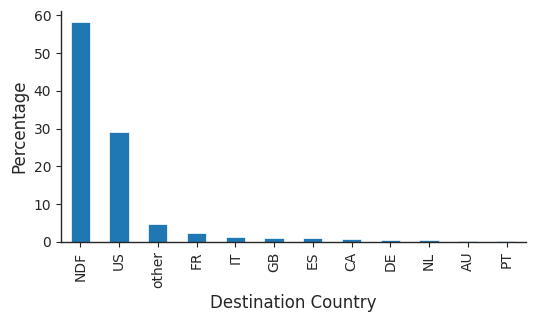

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
destination_percentage = df_train.country_destination.value_counts() / df_train.shape[0] * 100
destination_percentage.plot(kind='bar',color='#1f77b4')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

#fact
#57%的用戶並未下訂單，而有28%的用戶(占出國比例65%)去母國US

-unknown-    44.829024
FEMALE       29.534179
MALE         25.504683
OTHER         0.132115
Name: gender, dtype: float64


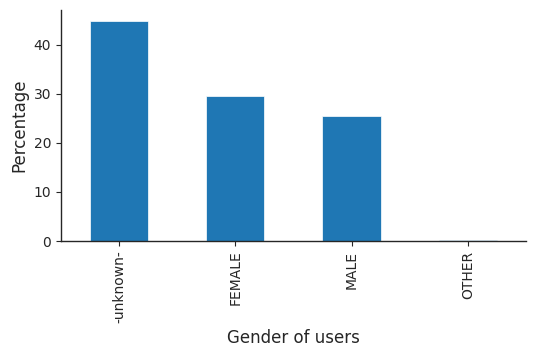

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
gender_percentage = df_train.gender.value_counts() / df_train.shape[0] * 100
print(gender_percentage)

gender_percentage.plot(kind='bar',color='#1f77b4')
plt.xlabel('Gender of users')
plt.ylabel('Percentage')
sns.despine()

#fact:
#有44.8%的用戶無性別
#男女比例差異不大，分別為 25.5% 與 29.5%

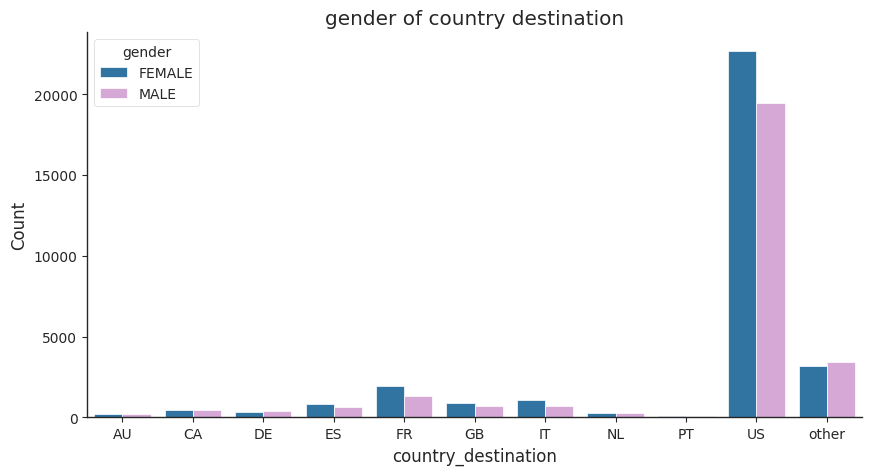

In [ ]:
counts = df_train.groupby(['country_destination', 'gender']).size().reset_index(name='Count')
counts = counts[counts['country_destination'] != 'NDF']
counts = counts[counts['gender'].isin(['FEMALE','MALE'])]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.barplot(data=counts,x='country_destination',y='Count',hue='gender',errorbar=None,ax=ax, palette=['#1f77b4','#dda0dd'])
plt.title('gender of country destination')
sns.despine()

**統計檢定 年齡在兩群是否差異**
* 下單用戶
* 活躍用戶

In [71]:
def gender_test(data1, data2):
  data1 = data1[data1['gender'].isin(['FEMALE','MALE'])]
  data2 = data2[data2['gender'].isin(['FEMALE','MALE'])]

  #test
  pop = np.array([len(data1['gender']), len(data2['gender'])])
  count = np.array([data1['gender'].value_counts()['MALE'], data2['gender'].value_counts()['MALE']])

  # 進行比例檢定
  stat, pval = proportions_ztest(count, pop)

  # 輸出結果
  print(f"比例檢定的統計量為 {stat:.3f}，p 值為 {pval:.3f}")

In [72]:
#下單用戶
no_ndf = df_train[df_train['country_destination']!= 'NDF']
ndf = df_train[df_train['country_destination']== 'NDF']

gender_test(no_ndf, ndf)

比例檢定的統計量為 0.584，p 值為 0.559


In [76]:
#活躍用戶
grouped_counts = df_sessions.groupby('user_id').size()
active_user = grouped_counts[grouped_counts > grouped_counts.describe()['25%']].index
no_active_user = grouped_counts[grouped_counts < grouped_counts.describe()['25%']].index

active_data = df_train[df_train['id'].isin(active_user)]
no_active_data = df_train[df_train['id'].isin(no_active_user)]

gender_test(active_data, no_active_data)

比例檢定的統計量為 -1.476，p 值為 0.140


In [84]:
ndf['gender'].value_counts()

FEMALE       29526
MALE         25966
-unknown-    11529
OTHER          159
Name: gender, dtype: int64

**age**

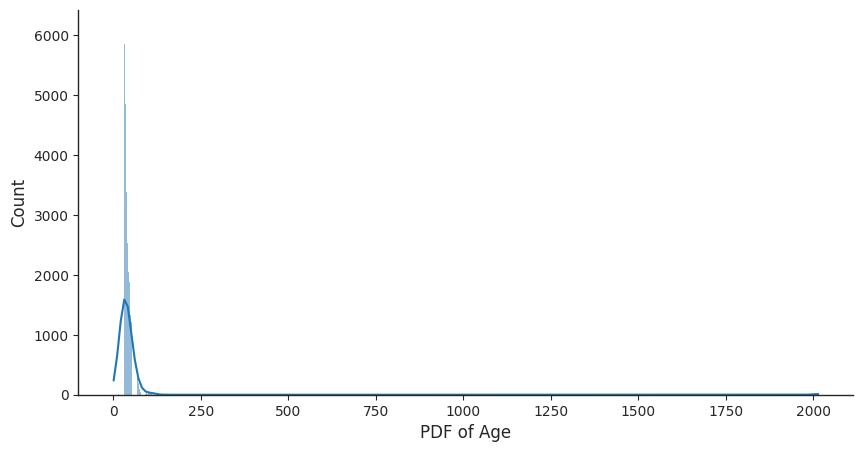

In [34]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.histplot(df_train.age.dropna(), kde=True, color='#1f77b4')
plt.xlabel('PDF of Age')
sns.despine()

#fact
#age有極端值出現，需處理

In [35]:
def explore_age(data):
  outlier_age = len(data['age'][(data['age']>100) & (data['age']<200)])
  inconsistent_age = len(data['age'][data['age']>200])
  percent = (outlier_age+inconsistent_age)/len(data)

  young_age = len(data['age'][data['age']<18])
  young_percent = (young_age)/len(data)

  return outlier_age, inconsistent_age, percent, young_age, young_percent

print(explore_age(df_train))
print(explore_age(df_test))

#fact
#不正常的年齡與小於18歲的比例少，僅1%與0.5%，敘述性統計方面可先忽略

(1566, 779, 0.01098612796379497, 158, 0.0007402167242130512)
(296, 49, 0.005555913424375161, 30, 0.0004831229064674053)


count    122932.000000
mean         36.562205
std          11.646124
min          18.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          99.000000
Name: age, dtype: float64


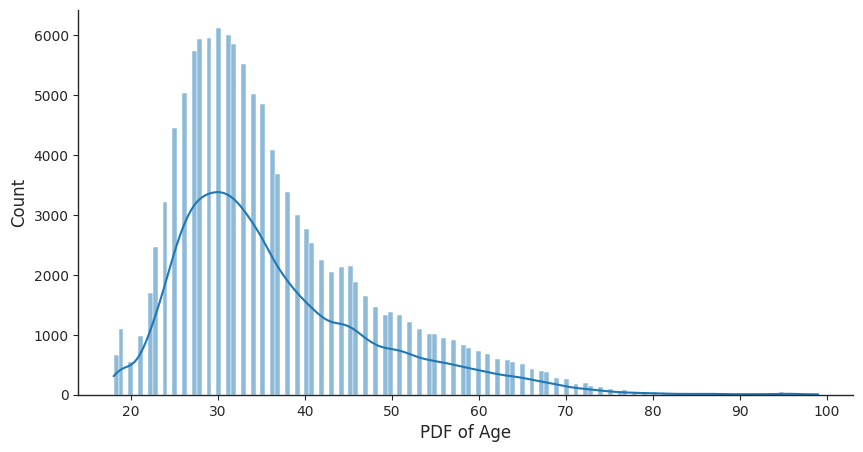

In [36]:
age_temp = df_train['age'][(df_train['age']>=18) & (df_train['age']<100)]

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.histplot(age_temp.dropna(), kde=True,color='#1f77b4')
print(age_temp.describe())
plt.xlabel('PDF of Age')
sns.despine()

**統計檢定 - 年齡平均是否有顯著差異**

In [77]:
def age_test(data1, data2):
  x = data1['age']
  y = data2['age']

  t_stat, p_val = ttest_ind(x, y)

  print(f"檢定統計量為 {t_stat:.3f}，p 值為 {pval:.3f}")

In [78]:
age_df = df_train[(df_train['age']>=18) & (df_train['age']<100)]
no_ndf = age_df[age_df['country_destination']!= 'NDF']
ndf = age_df[age_df['country_destination']!= 'NDF']

age_test(no_ndf, ndf)

檢定統計量為 0.000，p 值為 0.559


In [79]:
active_data = active_data[(active_data['age']>=18) & (active_data['age']<100)]
no_active_data = no_active_data[(no_active_data['age']>=18) & (no_active_data['age']<100)]

age_test(active_data, no_active_data)

檢定統計量為 -0.818，p 值為 0.559


In [150]:
def age_quantile(ages):
  # 計算分位數
  q10 = ages.quantile(0.1)
  q80 = ages.quantile(0.8)

  # 切割區間
  ages_in_range = ages[(ages >= q10) & (ages <= q80)]

  # 計算占比
  prop_in_range = len(ages_in_range) / len(ages)

  # 顯示區間和及占比
  print(f"年齡區間: {min(list(ages_in_range)), max(list(ages_in_range))}")
  print(f"年齡區間和: {ages_in_range.sum()}")
  print(f"占比: {prop_in_range}")

In [151]:
age_quantile(active_data['age'])
age_quantile(ndf['age'])

年齡區間: (24.0, 44.0)
年齡區間和: 685103.0
占比: 0.718758344459279
年齡區間: (25.0, 44.0)
年齡區間和: 1600588.0
占比: 0.7277165823161655


FEMALE    52.843983
MALE      47.156017
Name: gender, dtype: float64


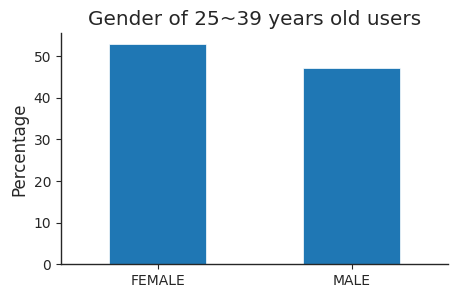

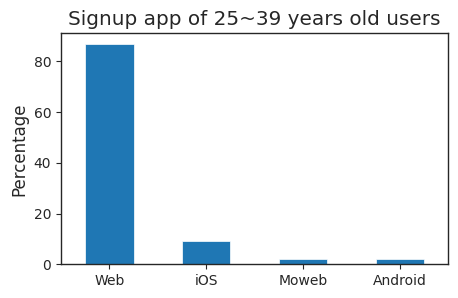

In [230]:
#了解25~39間的相關特徵分布等

certain_age = df_train[(df_train['age']>=25) & (df_train['age']<40)]

#gender
certain_age_gender = certain_age[certain_age['gender'].isin(['FEMALE','MALE'])]
gender_percentage = certain_age_gender.gender.value_counts() / certain_age_gender.shape[0] * 100
print(gender_percentage)

plt.figure(figsize=(5,3))
gender_percentage.plot(kind='bar',color='#1f77b4', rot=0)
plt.title('Gender of 25~39 years old users')
plt.ylabel('Percentage')
sns.despine()

#signup
plt.figure(figsize=(5,3))
signup_percentage = certain_age.signup_app.value_counts() / certain_age.shape[0] * 100
signup_percentage.plot(kind='bar',color='#1f77b4', rot=0)
plt.title("Signup app of 25~39 years old users")
plt.ylabel('Percentage')
plt.show()

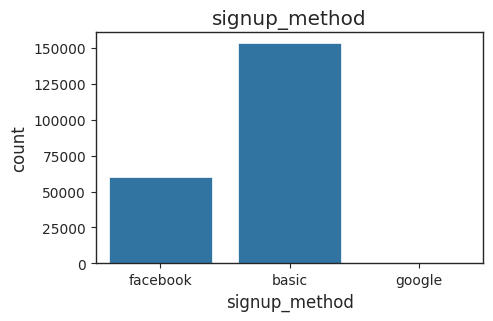

In [167]:
# signup method
plt.figure(figsize=(5,3))
ax = sns.countplot(x='signup_method', data=df_train, color='#1f77b4')
plt.title('signup_method')
plt.show()

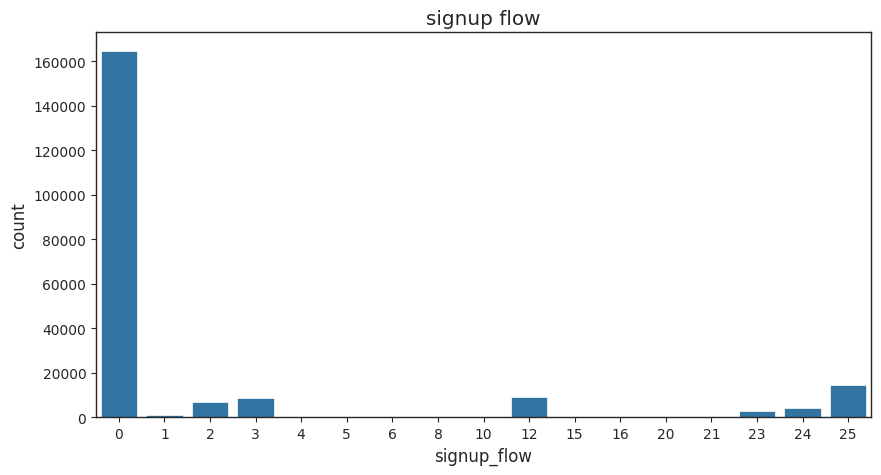

In [ ]:
# signup_flow share
plt.figure(figsize=(10,5))
ax = sns.countplot(x="signup_flow", data=df_train, color='#1f77b4')
plt.title("signup flow")
plt.show()

#fact:
#flow 0 占多數，除了 1,2,3,12,23,24和25外，其餘份額甚少

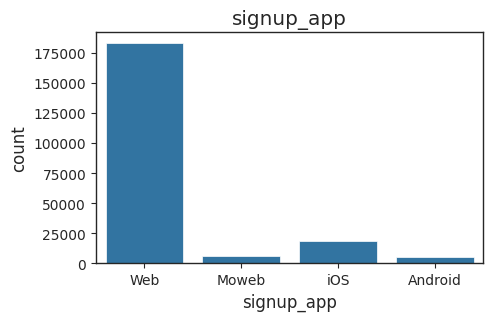

In [168]:
# signup app
plt.figure(figsize=(5,3))
ax = sns.countplot(x="signup_app", data=df_train, color='#1f77b4')
plt.title("signup_app")
plt.show()

#fact:
#最熱門為Web
#ios大於安卓

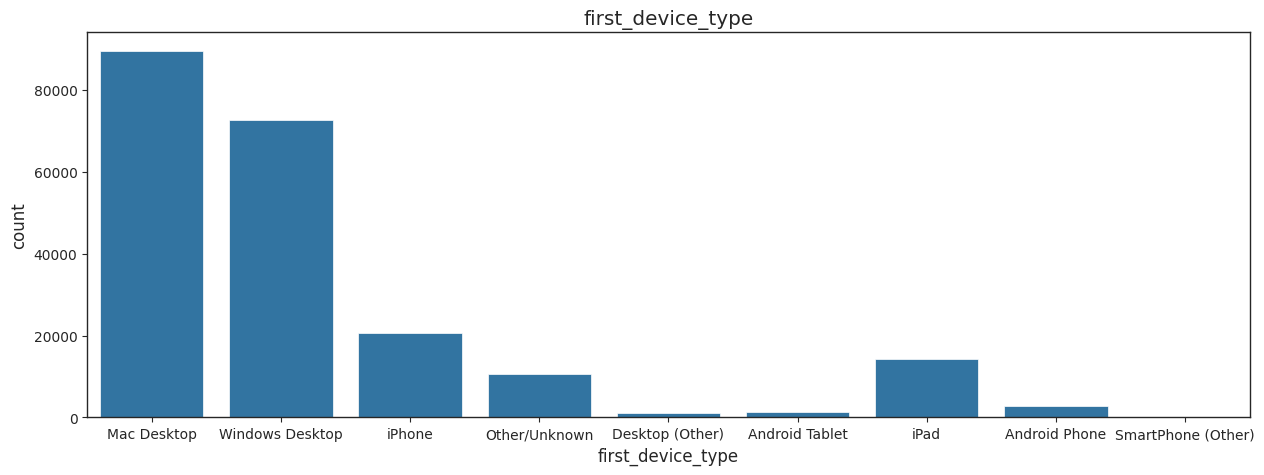

In [ ]:
# first_device_type
plt.figure(figsize=(15,5))
ax = sns.countplot(x="first_device_type", data=df_train, color='#1f77b4')
plt.title("first_device_type")
plt.show()

#fact:
#主要還是desktop

In [179]:
# daily,monthly and yearly data
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['date_account_created_day'] = df_train.date_account_created.dt.day_name()
df_train['date_account_created_month'] = df_train.date_account_created.dt.month
df_train['date_account_created_year'] = df_train.date_account_created.dt.year

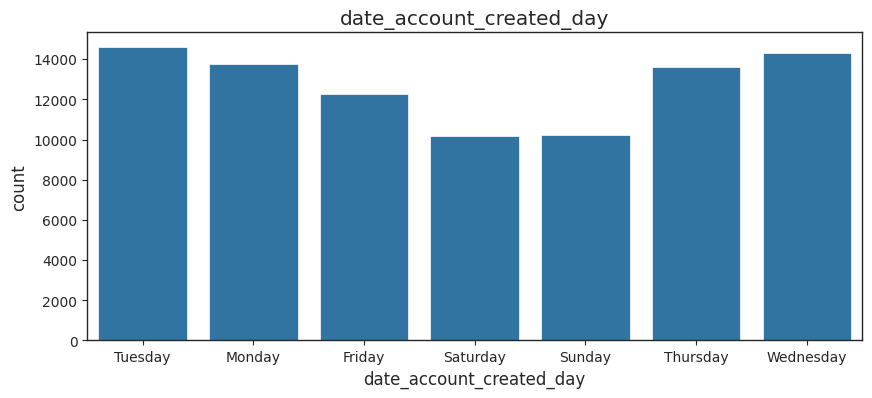

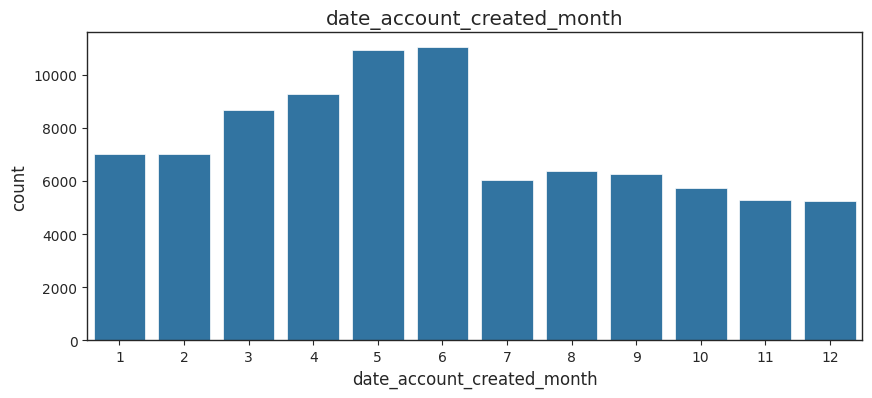

In [180]:
# date_account_created_day share

data = df_train[df_train['country_destination']!='NDF']
plt.figure(figsize=(10,4))
ax = sns.countplot(x='date_account_created_day', data=data, color='#1f77b4')
plt.title('date_account_created_day')
plt.show()

# date_account_created_month share
plt.figure(figsize=(10,4))
ax = sns.countplot(x='date_account_created_month', data=data, color='#1f77b4')
plt.title('date_account_created_month')
plt.show()

#fact:
#集中於春天與夏天前

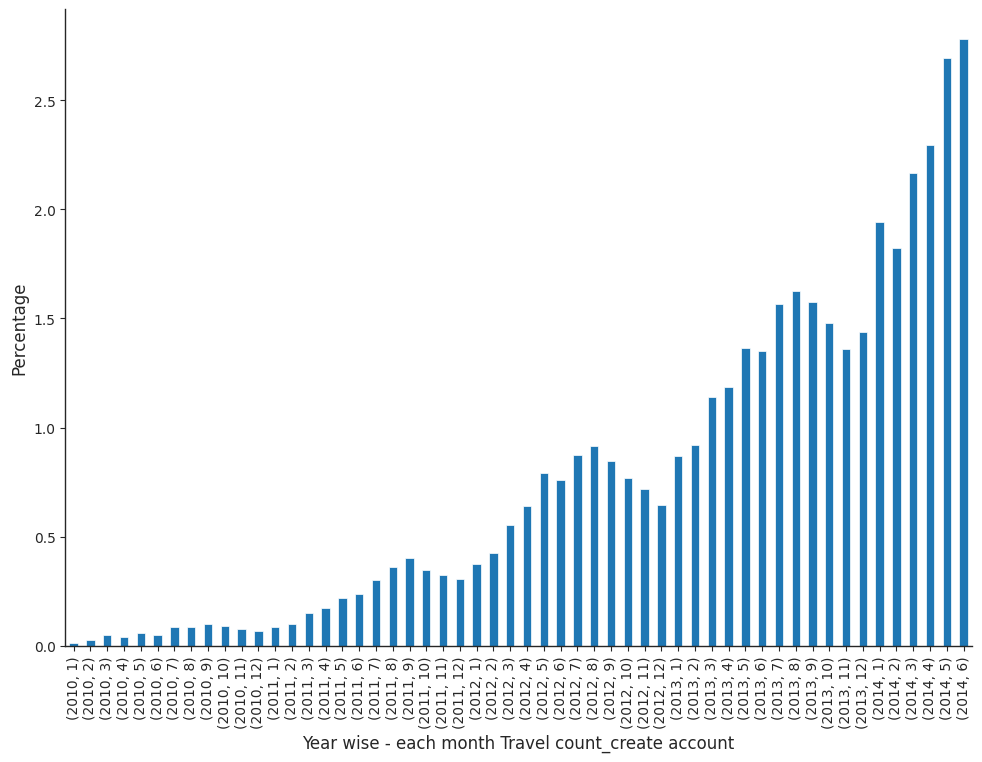

In [181]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
df_train['booked'] = df_train.country_destination.apply(lambda x:1 if x!='NDF' else 0 )
destination_percentage = df_train.groupby(['date_account_created_year','date_account_created_month']).booked.sum() / df_train.shape[0] * 100
destination_percentage.plot(kind='bar',color='#1f77b4')
plt.xlabel('Year wise - each month Travel count_create account')
plt.ylabel('Percentage')
sns.despine()

In [182]:
# daily,monthly and yearly data
df_train['date_first_booking'] = pd.to_datetime(df_train['date_first_booking'])
df_train['date_first_booking_day'] = df_train.date_first_booking.dt.day_name()
df_train['date_first_booking_month'] = df_train.date_first_booking.dt.month
df_train['date_first_booking_year'] = df_train.date_first_booking.dt.year

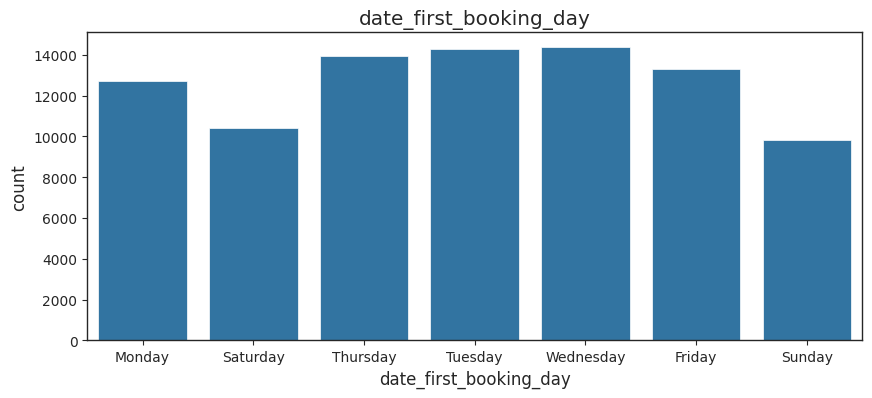

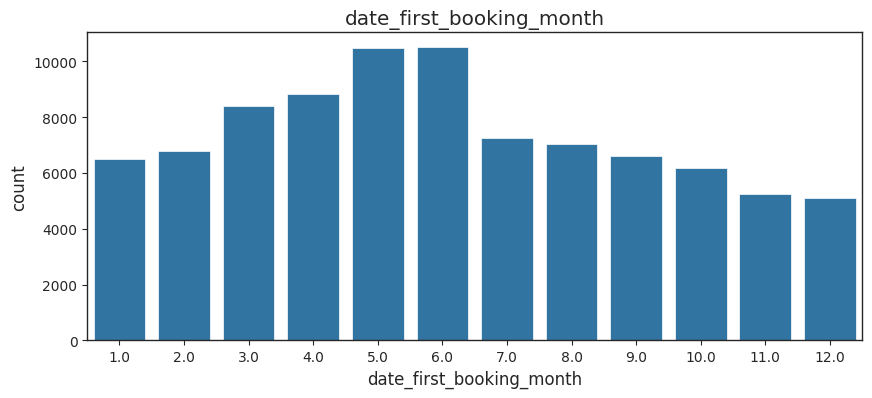

In [183]:
# date_first_booking_day share
data = df_train[df_train['country_destination']!='NDF']
plt.figure(figsize=(10,4))
ax = sns.countplot(x='date_first_booking_day', data=data, color='#1f77b4')
plt.title('date_first_booking_day')
plt.show()

# date_account_created_month share
plt.figure(figsize=(10,4))
ax = sns.countplot(x='date_first_booking_month', data=data, color='#1f77b4')
plt.title('date_first_booking_month')
plt.show()

#fact:
#集中於夏天前

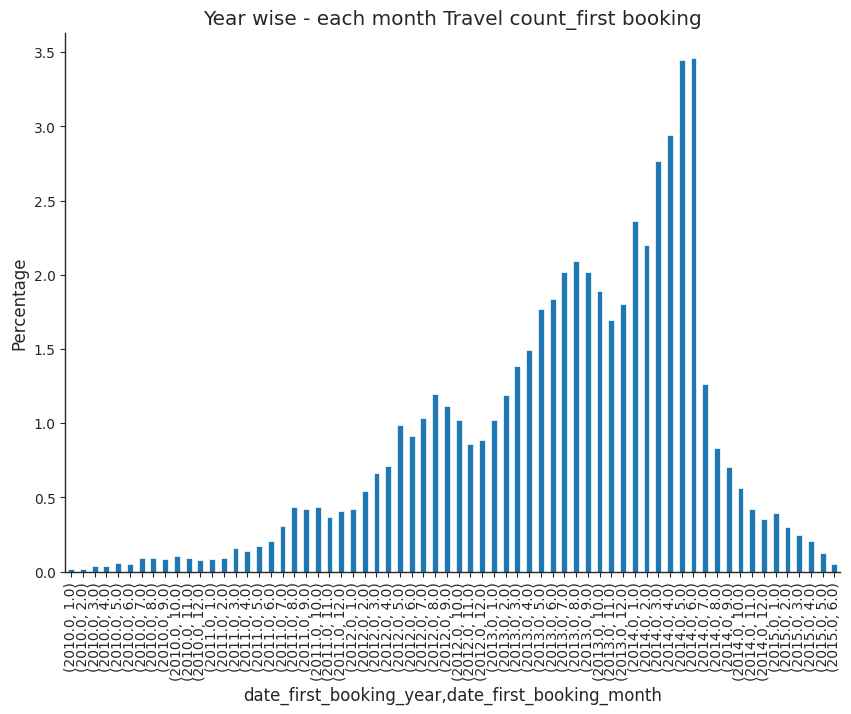

In [190]:
sns.set_style('ticks')

certain_age = df_train[(df_train['age']>=25) & (df_train['age']<40)]
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
destination_percentage = certain_age.groupby(['date_first_booking_year','date_first_booking_month']).booked.sum() / certain_age.shape[0] * 100
destination_percentage.plot(kind='bar',color='#1f77b4')
plt.title('Year wise - each month Travel count_first booking')
plt.ylabel('Percentage')
sns.despine()

#fact
#明顯有季節性變化